In [2]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 
import sklearn
import warnings 

from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier

plt.style.use('ggplot')


warnings.filterwarnings(action="ignore")



Veri Setinde  : <br>
<b>
BI-RADS assessment: 1 to 5 (ordinal)<br>
Age: patient's age in years (integer)<br>
Shape: mass shape: round=1 oval=2 lobular=3 irregular=4 (nominal)<br>
Margin: mass margin: circumscribed=1 microlobulated=2 obscured=3 ill-defined=4 spiculated=5 (nominal)<br>
Density: mass density high=1 iso=2 low=3 fat-containing=4 (ordinal)<br>
Severity: benign=0 or malignant=1 (binominal)<br>

</b>|
<br>

Yukarida verilen sutunlardan BI-RADS siniflandirmadan ne derece emin oldugumuzun gostergesidir. Bu sebeple modelimize bu ozelligi koymayacagiz. Modeli Age,Shape, Margin, Density ozelliklerini kullanarak Severity i tahmin etmeye calisacagiz.. 


In [3]:
column_names = ['BI-RADS','Age','Shape','Margin','Density','Severity']

data = pd.read_csv('MLCourse/mammographic_masses.data.txt',names= column_names,na_values='?')

In [4]:
data.drop(columns='BI-RADS',axis=1,inplace=True)
data.head()

,Age,Shape,Margin,Density,Severity
0,67.0,3.0,5.0,3.0,1
1,43.0,1.0,1.0,NaN,1
2,58.0,4.0,5.0,3.0,1
3,28.0,1.0,1.0,3.0,0
4,74.0,1.0,5.0,NaN,1


In [5]:
data.describe()

,Age,Shape,Margin,Density,Severity
count,956.000000,930.000000,913.000000,885.000000,961.000000
mean,55.487448,2.721505,2.796276,2.910734,0.463059
std,14.480131,1.242792,1.566546,0.380444,0.498893
min,18.000000,1.000000,1.000000,1.000000,0.000000
25%,45.000000,2.000000,1.000000,3.000000,0.000000
50%,57.000000,3.000000,3.000000,3.000000,0.000000
75%,66.000000,4.000000,4.000000,3.000000,1.000000
max,96.000000,4.000000,5.000000,4.000000,1.000000


#### Missing Values
Veride bulunan missing value lari median yada mean ile doldurabiliriz. Baska yontemlerde denenebilir ancak bu sekilde kolaylikla yapabiliriz. 
Missing value lar cok fazla olmadigi icin burada bu satirlari dusurerek de devam edebiliri. Cok fark yaratmayacaktir. 

In [6]:
data.isna().sum()

Age          5
Shape       31
Margin      48
Density     76
Severity     0
dtype: int64

In [7]:
data.fillna(value = data.median(),inplace = True)
print(f'Veri setinde {data.isna().sum().sum()} missing value bulunuyor..')

Veri setinde 0 missing value bulunuyor..


Insanlarda bulunan tumorlerin iyi yada kotu huylu olduklarini Severity verisinden ogreniyoruz. Elimizde bulunan veri setinde benign ya da malignant olma durumlari dengeli dagilmis gorunyor. Bunu 2 sekilde kontrol edebiliriz. 

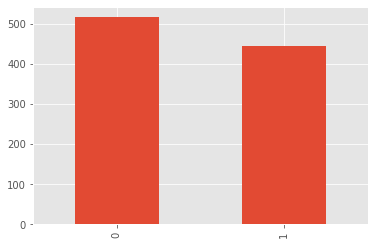

In [8]:
data.Severity.value_counts().plot(kind='bar')
plt.show()

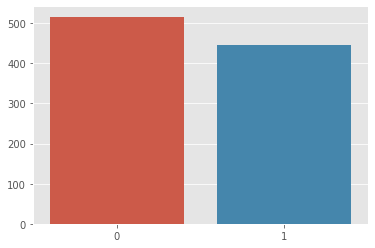

In [9]:
sns.barplot(x=data.Severity.value_counts().index, y= data.Severity.value_counts().values,)
plt.show()

Malignant olanlarin daha cok ileri yaslarda olanlarda oldugunu soyleyebiliriz.

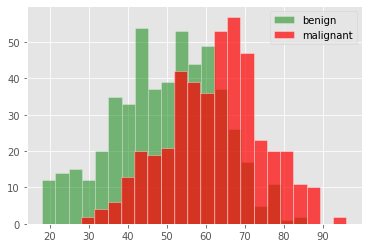

In [10]:
plt.hist('Age',data = data[data['Severity']==0] ,bins=20,color='g',alpha=.5,label='benign',edgecolor='w')
plt.hist('Age',data = data[data['Severity']==1],bins=20, color ='r',alpha=.7,label='malignant',edgecolor='w')
plt.legend()
plt.show()

Korelasyonlara bakarak hangi featurelarin Severity i tahmin etmemizde etkili olacagini ortaya koyabiliriz. <br>
Shape,Age,Margin bilgilerinin yuksek pozitif korelasyona sahip oldugunu, Density featurerunun direkt olarak Severityi tahmin etmemizde etkili olmadigni gorebiliriz. 

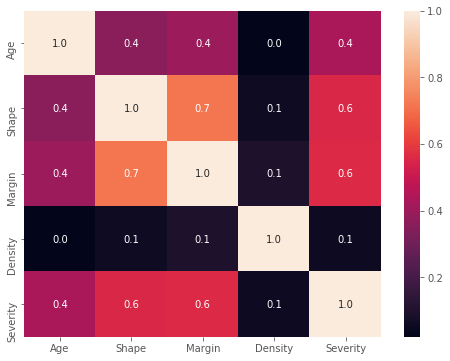

In [11]:
plt.figure(figsize=(8,6))
sns.heatmap(data.corr(),annot=True,fmt='.1f')
plt.show()

Veri setini daha ayrintili inceleyerek ve baska grafikler olusturak daha ayrintili ogrenebilriz ancak cok kapsamli ve karmasik bir veri seti olmadigi icin gorsellestirme islemlerini birakip machine learning modelleri kullanacagimiz kisma gecelim. 

In [12]:
X = data.drop(columns=['Severity']).values
y = data['Severity'].values
feature_names = data.columns[:-1]

In [13]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.2)

Data Leakage yasanmamasi icin once train-test olarak verimizi ayirdik. Ayirdiktan sonra train seti uzerinde fit.transform daha sonra test uzerinde sadece transform islemi gerceklestiricez.  <br> 
Kullanacagimiz modellerin bazilari verileri normalize edilmis halde isteyecektir. Bu sebeple verileri normalize ediyoruz. <br>

Normalizasyon islemi ile en temelde featurelari ayni scale e getiriyoruz. orn 0-1 arasina , (-1)-1 arasina
standart_scaler = z = (x - u) / s

In [14]:
# Bir cok yontem kullanilabilir min-max, std ... 

stdScaler = StandardScaler()

X_train_normalized = stdScaler.fit_transform(X_train)
X_test_normalized = stdScaler.transform(X_test)

In [15]:
X_train_normalized[:2]

array([[ 0.02471513, -1.44987032, -1.17808419,  0.20292723],
       [ 1.04888155,  1.00638058,  0.7916589 ,  0.20292723]])

### Decision Tree

In [16]:
clf = DecisionTreeClassifier(max_depth=3)
clf.fit(X_train_normalized,y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=3, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [17]:
print(f'Train Accuray : {clf.score(X_train_normalized,y_train)}')
print(f'Test Accuracy : {clf.score(X_test_normalized,y_test)}')

Train Accuray : 0.8098958333333334
Test Accuracy : 0.7512953367875648


Tahmin ettigimic gibi Density ozelligi modelin kararlarinda cok etkili ola bir feature olmadi. <br>

En etkili ozelliginde Shape oldugunu net bir sekile gorebiliyoruz. 

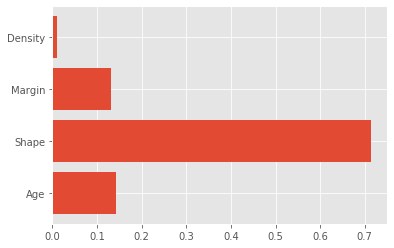

In [18]:
plt.barh(feature_names,clf.feature_importances_)
plt.show()

#### K-FOLD CROSS VALIDATION 

In [19]:
X_normalized = stdScaler.fit_transform(X)
scores = cross_val_score(clf,X,y,cv=10)
print(scores.mean()) # 10 fold cross validation ile modelin basarisi olcumledik. 
# cikan sonuclara gore ortalama 79.6 basari elde edebiliyoruz. 

0.7960695876288659


### Randomforest 

In [20]:
clf = RandomForestClassifier()
clf.fit(X_train_normalized,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [21]:
y_train_pred = clf.predict(X_train_normalized)
y_test_pred = clf.predict(X_test_normalized)

print(f'Train Accuracy : {accuracy_score(y_train_pred,y_train)}')
print(f'Test Accuracy : {accuracy_score(y_test_pred,y_test)}')

Train Accuracy : 0.9010416666666666
Test Accuracy : 0.7461139896373057


### SVM 

In [22]:
clf = SVC()
clf.fit(X_train_normalized,y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [23]:
print(f'Train Accuray : {clf.score(X_train_normalized,y_train)}')
print(f'Test Accuracy : {clf.score(X_test_normalized,y_test)}')

Train Accuray : 0.8190104166666666
Test Accuracy : 0.7772020725388601


### K-Neares Neighbors

In [24]:
clf = KNeighborsClassifier(n_neighbors=10)
clf.fit(X_train_normalized,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                     weights='uniform')

In [25]:
print(f'Train Accuray : {clf.score(X_train_normalized,y_train)}')
print(f'Test Accuracy : {clf.score(X_test_normalized,y_test)}')

Train Accuray : 0.8190104166666666
Test Accuracy : 0.7823834196891192


### KNN - ELBOW METHOD 
Elbow metodu kullanarak. KNN de kullandigimiz n_neighbors degerini belirleyebiliz. <br>  
n_neighbors degerini arttirarak hatalari hesaplayip. Optimal n_neighbors degerini bulmaya calisacagiz. 

In [26]:
errors_ = []
for i in range(1,50):
    clf = KNeighborsClassifier(n_neighbors=i)
    clf.fit(X_train_normalized,y_train)
    errors_.append(np.mean(clf.predict(X_test_normalized)!=y_test))
    
    

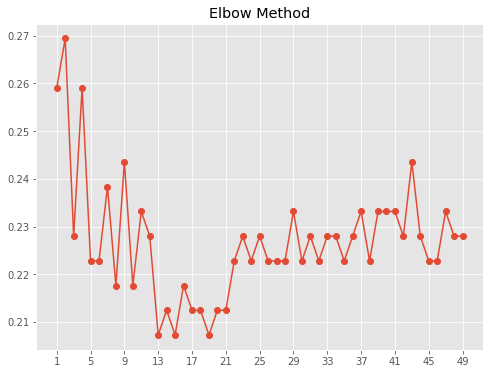

In [27]:
plt.figure(figsize=(8,6))
plt.xticks(range(1,52,4))
# grafikten gorilecegi uzere en dusuk error n_neigbors = 17 de almisiz. 
plt.plot(range(1,50),errors_,marker='o',)
plt.title('Elbow Method')
plt.show()

### NAIVE BAYES 


In [28]:
# multinomaial naive bayes kullanmak icin featurelari min-max scaler ile scale ediyoruz.

In [29]:
minMaxScaler = MinMaxScaler()
X_train_normalized_m = minMaxScaler.fit_transform(X_train)
X_test_normalized_m = minMaxScaler.transform(X_test)

In [30]:
clf = MultinomialNB()
clf.fit(X_train_normalized_m,y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [31]:
print(f'Train Accuray : {clf.score(X_train_normalized_m,y_train)}')
print(f'Test Accuracy : {clf.score(X_test_normalized_m,y_test)}')

Train Accuray : 0.7825520833333334
Test Accuracy : 0.7461139896373057


### SVM - Farkli kernel kullanarak

In [32]:
clf = SVC(kernel='poly')
clf.fit(X_train_normalized,y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='poly',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [33]:
print(f'Train Accuray : {clf.score(X_train_normalized,y_train)}')
print(f'Test Accuracy : {clf.score(X_test_normalized,y_test)}')

Train Accuray : 0.8059895833333334
Test Accuracy : 0.7461139896373057


In [34]:
clf = SVC(kernel='sigmoid')
clf.fit(X_train_normalized,y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='sigmoid',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [35]:
print(f'Train Accuray : {clf.score(X_train_normalized,y_train)}')
print(f'Test Accuracy : {clf.score(X_test_normalized,y_test)}')

Train Accuray : 0.7174479166666666
Test Accuracy : 0.7098445595854922


### Grid Search

In [36]:
grid_params = {'kernel':["rbf","poly",'linear','sigmoid'],'C':np.arange(1,10)}

clf = SVC()
grid_search= GridSearchCV(clf,grid_params,cv=10)

In [37]:
grid_search.fit(X_normalized,y)

GridSearchCV(cv=10, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
                         'kernel': ['rbf', 'poly', 'linear', 'sigmoid']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [38]:
print(f'En iyi parametreler : {grid_search.best_params_}')
print(f'En yuksek accuracy : {grid_search.best_score_}')

En iyi parametreler : {'C': 2, 'kernel': 'rbf'}
En yuksek accuracy : 0.8033290378006871


### Model Evaluate 
Modellerin basarilarini olcmek icin her seferinde tek tek yazmak yerine bir method olusturarak her seferinde bu method uzerinden modellerimizi degerlendirebilirdik. Ama ben aliskanlik edinebilmeniz icin her seferinde tek tek yazmanin daha ogretici oldugunu dusunuyorum. 

In [39]:
def evaluate(clf,name):
    clf.fit(X_train_normalized,y_train)
    y_pred = clf.predict(X_test_normalized)
    print(name)
    print("Accuracy Score : ",accuracy_score(y_test,y_pred))
    print("Precision Score : ",precision_score(y_test,y_pred))
    print("Recall Score : ",recall_score(y_test,y_pred))    
    print("F1 Score : ",f1_score(y_test,y_pred)) 
    print("Cross val Score : ",cross_val_score(clf,X_test_normalized,y_test,cv=10).mean())
    print("-----"*10)

In [40]:
lr = LogisticRegression()
evaluate(lr,"Logistic Regression")

Logistic Regression
Accuracy Score :  0.7772020725388601
Precision Score :  0.6914893617021277
Recall Score :  0.8227848101265823
F1 Score :  0.7514450867052023
Cross val Score :  0.7455263157894737
--------------------------------------------------


## ENSEMBLE LEARNING 
Random forest da normalde ensemble modellerdendir ancak onu decision treeden sonra gostermek daha mantikli geldi. 
<br> Ensemble learningde amac gorece zayif modellerden guclu modeller eldetmektir. 
### XGBOOST
Gradientboosting daha hızlı ve performansı fazladır. Gradient boost sequential olduğu için yavaştır. <br>
paralel çalışır
hem lasso hem rigge regression kullanılır 

In [41]:
import xgboost 

model = xgboost.XGBClassifier()

evaluate(model,'XGBOOST')

XGBOOST
Accuracy Score :  0.7512953367875648
Precision Score :  0.691358024691358
Recall Score :  0.7088607594936709
F1 Score :  0.7
Cross val Score :  0.7407894736842106
--------------------------------------------------


### Voting Classifier
Zayif modellerin birlesip guclu bir model olusturdugu modellerdir. 

In [42]:
estimators = []

model1 = LogisticRegression()
estimators.append(("logistic",model1))

model2 = DecisionTreeClassifier()
estimators.append(("cart",model2))

model3 = SVC()
estimators.append(('svm', model3))

model4 = KNeighborsClassifier()
estimators.append(("KNeighborsClassifier",model4))

ensemble = VotingClassifier(estimators)

evaluate(ensemble,'VOTING CLASSIFIER')

VOTING CLASSIFIER
Accuracy Score :  0.7823834196891192
Precision Score :  0.7176470588235294
Recall Score :  0.7721518987341772
F1 Score :  0.7439024390243902
Cross val Score :  0.7607894736842106
--------------------------------------------------


<b> Tabi ki  denenecek bir cok parametre ve model bulunuyor. Ancak temel duzeyde genel bir izlenim vermesi icin bu notebooku hazirladim. <b> 